** LSTM پیش‌بینی قیمت سهام با **

In [1]:
# نصب کتابخانه‌های مورد نیاز
!pip install yfinance
!pip install tensorflow

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
# 1. دانلود داده‌ها از Yahoo Finance
stock_symbol = 'AAPL'  # نماد سهام مورد نظر (مثال: اپل)
data = yf.download(stock_symbol, start='2015-01-01', end='2023-01-01')

# 2. استفاده از قیمت بسته شدن سهام
data = data[['Close']]  # فقط قیمت بسته شدن را انتخاب می‌کنیم

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Date | Open | High | Low | Close | Adj Close | Volume


In [4]:
# 3. نرمال‌سازی داده‌ها
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# 4. ساخت دنباله‌های داده‌ای (برای آموزش مدل)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # تعداد روزهایی که برای پیش‌بینی استفاده می‌کنیم
X, y = create_dataset(scaled_data, time_step)

# 5. تقسیم داده‌ها به داده‌های آموزش و تست
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 6. تغییر شکل داده‌ها برای ورودی LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [6]:
# 7. ساخت مدل LSTM با بهبودهای مختلف
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # اضافه کردن Dropout برای جلوگیری از overfitting
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))  # اضافه کردن Dropout برای جلوگیری از overfitting
model.add(Dense(units=1))  # خروجی پیش‌بینی قیمت

# 8. تنظیم optimizer و کاهش learning rate
optimizer = Adam(learning_rate=0.001)  # کاهش learning rate به 0.001
model.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# 9. آموزش مدل با تعداد epochs بیشتر
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0109 - val_loss: 0.0016
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 9.0485e-04 - val_loss: 0.0036
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 8.2936e-04 - val_loss: 0.0015
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 7.7156e-04 - val_loss: 0.0015
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 7.0801e-04 - val_loss: 0.0034
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 6.4167e-04 - val_loss: 0.0034
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 7.4989e-04 - val_loss: 0.0020
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 6.1734e-04 - val_loss: 0.0031
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 7.1297e-04 - val_loss: 0.0011
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 4.8477e-04 - val_loss: 0.0064
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 7.8336e-04 - val_loss: 0.0014
Epoch 12/2

In [8]:
# 10. پیش‌بینی و ارزیابی مدل
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)  # برگرداندن مقیاس به حالت اصلی
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # برگرداندن مقیاس داده‌های واقعی


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


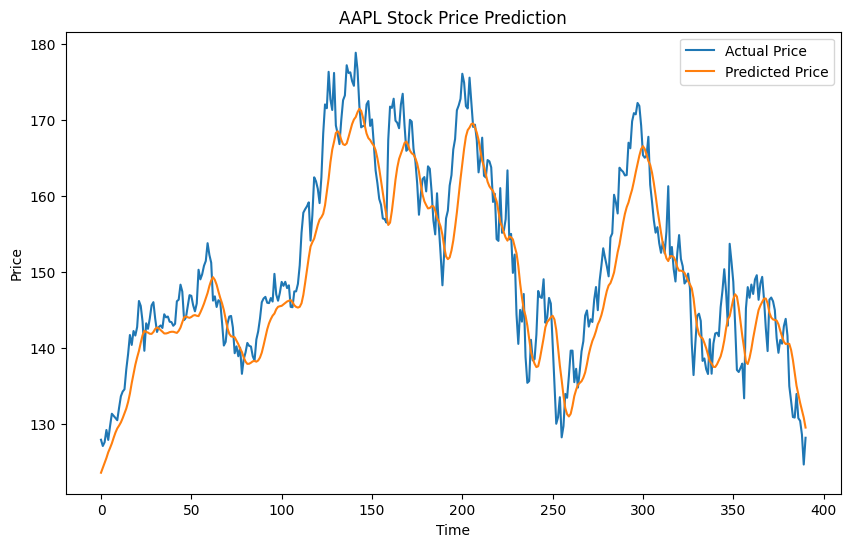

In [9]:
# 11. نمایش نتایج
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label="Actual Price")
plt.plot(predicted_price, label="Predicted Price")
plt.title(f"{stock_symbol} Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:

# نصب کتابخانه‌های مورد نیاز
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# محاسبه MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_actual, predicted_price)
print(f"Mean Absolute Error (MAE): {mae}")

# محاسبه MSE (Mean Squared Error)
mse = mean_squared_error(y_test_actual, predicted_price)
print(f"Mean Squared Error (MSE): {mse}")

# محاسبه RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# محاسبه R² (R-squared)
r2 = r2_score(y_test_actual, predicted_price)
print(f"R-squared (R²): {r2}")



Mean Absolute Error (MAE): 4.101961101717351
Mean Squared Error (MSE): 26.4167306644549
Root Mean Squared Error (RMSE): 5.1397208741774
R-squared (R²): 0.8308792151944562


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# فرض می‌کنیم که predicted_price و y_test_actual از کد قبلی شما هستند
# محاسبه MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test_actual, predicted_price)
print(f"Mean Absolute Error (MAE): {mae}")

# محاسبه MSE (Mean Squared Error)
mse = mean_squared_error(y_test_actual, predicted_price)
print(f"Mean Squared Error (MSE): {mse}")

# محاسبه RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# محاسبه R² (R-squared)
r2 = r2_score(y_test_actual, predicted_price)
print(f"R-squared (R²): {r2}")

# محاسبه MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test_actual - predicted_price) / y_test_actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

# در صورتی که نیاز به SMAPE داشته باشید، می‌توانید آن را هم محاسبه کنید
smape = 100 * np.mean(2 * np.abs(predicted_price - y_test_actual) / (np.abs(predicted_price) + np.abs(y_test_actual)))
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape}")


Mean Absolute Error (MAE): 5.845922621314782
Mean Squared Error (MSE): 48.53601848901601
Root Mean Squared Error (RMSE): 6.96677963545683
R-squared (R²): 0.6892707962728546
Mean Absolute Percentage Error (MAPE): 3.815714682667533
Symmetric Mean Absolute Percentage Error (SMAPE): 3.9108802073864357
